In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries, concatenate
from darts.datasets import AirPassengersDataset
from darts.metrics import mape
from darts.models import NaiveSeasonal, NaiveDrift
from darts.utils.statistics import plot_acf, check_seasonality, plot_residuals_analysis

In [2]:
# Load data
series = AirPassengersDataset().load()

# Splitting
series1, series2 = series.split_after(0.75)

# Slicing
series1, series2 = series[:-36], series[-36:]

# Arithemtic
noise =  TimeSeries.from_times_and_values(
    series.time_index,
    np.random.randn(len(series))
)
noisy_series = (series / 2 + 20 * noise - 10)

# Concatenate
double_series = (series - 20).stack(series)

In [3]:
# Timeseries features
series_with_month = series.add_datetime_attribute("month")
series_with_month_day = series_with_month.add_datetime_attribute("day")
series_with_holidays = series.add_holidays("US")

<Axes: xlabel='Month'>

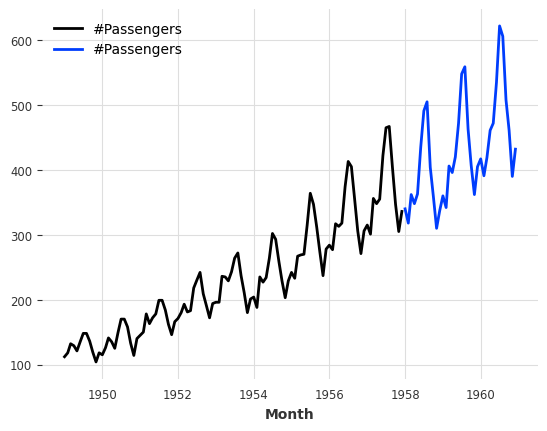

In [4]:
# Trainig models
train_series, valid_series = series.split_before(pd.Timestamp("19580101"))
train_series.plot()
valid_series.plot()

<Axes: xlabel='Month'>

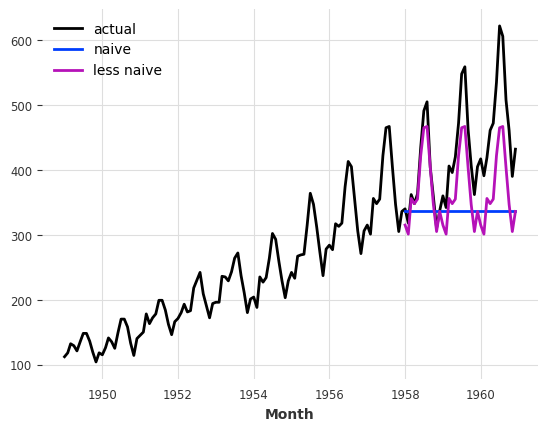

In [5]:
naive_model = NaiveSeasonal(K=1)
naive_model.fit(train_series)
naive_forecast = naive_model.predict(36)

less_naive = NaiveSeasonal(K=12)
less_naive.fit(train_series)
less_naive_forecast = less_naive.predict(36)

series.plot(label="actual")
naive_forecast.plot(label="naive")
less_naive_forecast.plot(label="less naive")

<Axes: xlabel='Month'>

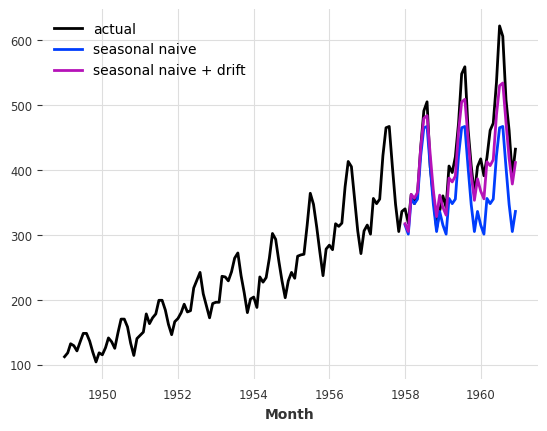

In [6]:
# Naive with drift
drift_model = NaiveDrift()
drift_model.fit(train_series)
drift_forecast = drift_model.predict(36)

combined_forecast = less_naive_forecast + drift_forecast - train_series.last_value()

series.plot(label="actual")
less_naive_forecast.plot(label="seasonal naive")
combined_forecast.plot(label="seasonal naive + drift")


In [7]:
error = mape(series, combined_forecast)
print(f"Combined forecast error {error:.2f}%")

Combined forecast error 5.66%


In [8]:
# Try out several models
from darts.models import ExponentialSmoothing, TBATS, AutoARIMA, Theta


def eval_model(model):
    model.fit(train_series)
    forecast = model.predict(len(valid_series))
    print(f"MAPE for {model}: {mape(valid_series, forecast):.2f}%")


eval_model(ExponentialSmoothing())
eval_model(TBATS())
eval_model(AutoARIMA())
eval_model(Theta())

MAPE for ExponentialSmoothing(): 5.11%
MAPE for TBATS(): 5.87%
MAPE for AutoARIMA(): 11.65%
MAPE for Theta(): 8.15%


  0%|          | 0/58 [00:00<?, ?it/s]

Average MAPE: 4.36


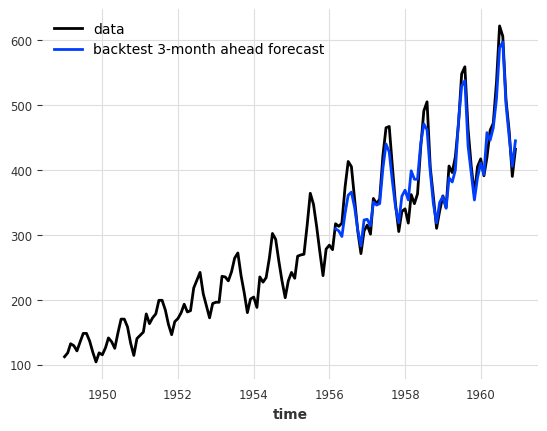

In [9]:
# Backtesting
backtest_parameters = {
    "series": series,
    "start": pd.Timestamp("1956-01-01"),  # start of validation period for backtesting
    "forecast_horizon": 3,
    "verbose": True,
}

model = ExponentialSmoothing()
backtest_results = model.historical_forecasts(last_points_only=True, ** backtest_parameters)

series.plot(label="data")
backtest_results.plot(label="backtest 3-month ahead forecast")
print(f"Average MAPE: {mape(series, backtest_results):.2f}")

  0%|          | 0/20 [00:00<?, ?it/s]

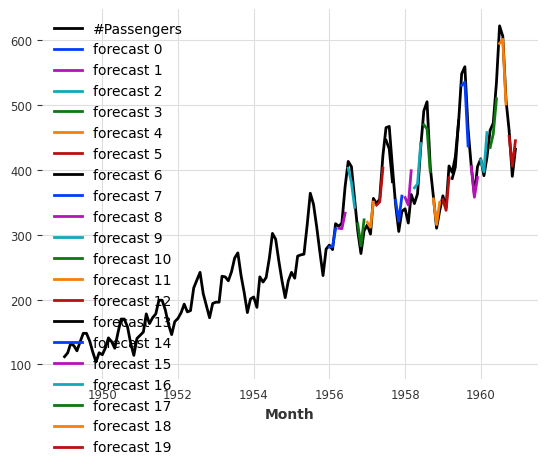

In [10]:
# Plot the entire forecasting horizon, rather than the last point only
model = ExponentialSmoothing()
backtest_results_all = model.historical_forecasts(last_points_only=False, stride=3, **backtest_parameters)

series.plot()
for idx, hfc in enumerate(backtest_results_all):
    hfc.plot(label=f"forecast {idx}");

MAPE Exp Smoothing historical forecasts: 3.68


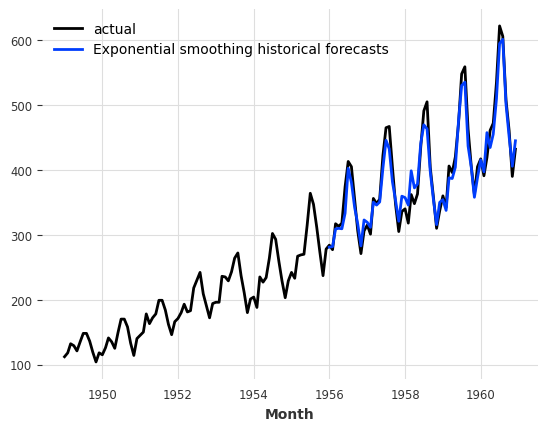

In [11]:
all_forecasts = concatenate(backtest_results_all)
series.plot(label="actual")
all_forecasts.plot(label="Exponential smoothing historical forecasts")
print(f"MAPE Exp Smoothing historical forecasts: {mape(series, all_forecasts):.2f}")

  0%|          | 0/58 [00:00<?, ?it/s]

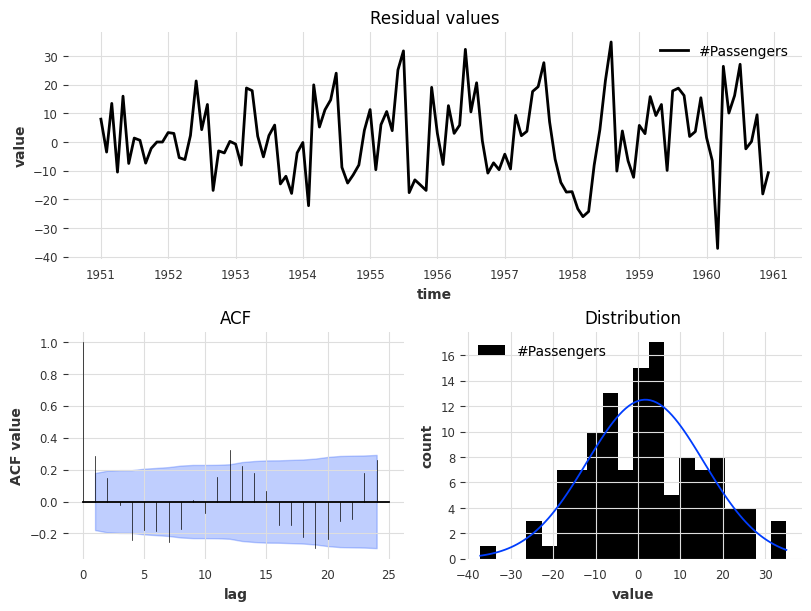

In [16]:
# Error analysis
model = ExponentialSmoothing(seasonal_periods=12)
historical_forecasts = model.historical_forecasts(last_points_only=True, **backtest_parameters)
plot_residuals_analysis(model.residuals(series));

In [14]:
model.residuals(series)

<TimeSeries (DataArray) (time: 120, component: 1, sample: 1)> Size: 960B
array([[[ 7.99999193e+00]],

       [[-3.49998896e+00]],

       [[ 1.34999913e+01]],

       [[-1.05000762e+01]],

       [[ 1.60260695e+01]],

       [[-7.47860478e+00]],

       [[ 1.38471165e+00]],

       [[ 6.13184510e-01]],

       [[-7.36357825e+00]],

       [[-2.21510405e+00]],

...

       [[-3.71569284e+01]],

       [[ 2.64617815e+01]],

       [[ 1.01268732e+01]],

       [[ 1.62176116e+01]],

       [[ 2.71675061e+01]],

       [[-2.38074033e+00]],

       [[ 2.03724889e-01]],

       [[ 9.53372570e+00]],

       [[-1.81335238e+01]],

       [[-1.07085235e+01]]])
Coordinates:
  * time       (time) datetime64[ns] 960B 1951-01-01 1951-02-01 ... 1960-12-01
  * component  (component) object 8B '#Passengers'
Dimensions without coordinates: sample
Attributes:
    static_covariates:  None
    hierarchy:          None